In [1]:
#%%%%% Load all the variables
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import ConvLSTM2D, Bidirectional
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import Model,layers
from keras.layers import Input,LSTM, Dense
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
import zipfile
import os
from PIL import Image
from numpy import save
from math import cos, sin
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import widgets, HBox

import imageio as io
import cv2
import glob
import zipfile
import shutil
from scipy.ndimage import rotate

import random
from random import shuffle

In [9]:
#%%%%% Set the random number seed for reproducibility
def set_seeds(seed=42):
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    #random.seed(seed)

# Call the function to set seeds
set_seeds(42)

# Set session configuration to be deterministic
session_config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_config)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
##############################################################################
##############################################################################
# Step 1 Load the images and create Training and validation dataset arrays
##############################################################################
##############################################################################

In [12]:
#%%%%% Unzip and load the images zip file
path_to_zip_file = r'images_zip_file'
directory_to_extract_to = 'directory_to_extract_images_zip_file'
print(os.path.isfile(path_to_zip_file))  

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
    

True


In [ ]:
#%%%%% Checking the number of images files in each image_IC sub folder within the images_SDC folder 
######### SDC
NNN=0
tt=0
for NNN in range(1,83):
    path = r'SDC_images_Folder/images_SDC_IC_'+str(NNN)
    all_files = sorted(glob.glob(os.path.join(path,"*.png")))
    if len(all_files)>0:
        tt=tt+1
        print(NNN,len(all_files))
print(tt)

######### Spiral QP
NNN=0
tt=0
for NNN in range(1,52):
    path = r'Spiral_QP_images_Folder/images_QP_IC_'+str(NNN)
    all_files = sorted(glob.glob(os.path.join(path,"*.png")))
    print(NNN,len(all_files))
    tt=tt+1
print(tt)

In [1]:
#%%%%%% Few input Parameters
Tlength=2 #### Number of images 1 for input and 1 for output
training_data_time=10 #### time in ms

In [ ]:
#################### Number of images_IC files containing individual SDC or Spiral QP events IDs that are used for training and validation 
Noise_Num_train_SDC=np.arange(0,35)
Noise_Num_val_SDC=np.arange(36,51)
Noise_Num_train_Spiral_QP=np.arange(1,36)
Noise_Num_val_Spiral_QP=np.arange(36,51)

In [ ]:
start_time=time.time()
############################### Creating the training dataset array##########################
#%%%%%%%%%%%%%%%% 1. SDC dataset %%%%%%%%%%%%%%%

NNN=0
img_no=0
for NNN in range(len(Noise_Num_train_SDC)):

    path = r'SDC_images_Folder/images_IC_'+str(Noise_Num_train_SDC[NNN])

    all_files = sorted(glob.glob(os.path.join(path,"*.png")))
    #print(len(all_files))
    images = np.empty(())
    i=0
    for filename in all_files:
        i=i+1
        #if i%100==0:
            #print(i)
        
        img=Image.open(filename)
        img=np.array(img)
        if i==1:
            img=np.expand_dims(img,axis=0)
            images=img
        else:    
            img=np.expand_dims(img,axis=0)
            images=np.append(images,img,axis=0)

    print(NNN,len(all_files))

    NN=images.shape[0]
    dataset=images
    nSamples=dataset.shape[0]
    fps=Tlength
    L=NN-fps
    h=dataset.shape[1]
    w=dataset.shape[2]
    c=dataset.shape[3]

    image_files = []
    image_files1 = []
    xx=np.zeros((L,h,w,c))
    yy=np.zeros((L,h,w,c))
    
    for i in range(L):
        r=i

        for j in range(r,fps+r):
            imgs=dataset[j,:,:,:]/255
            imgs1=dataset[j+1,:,:,:]/255
        #xx[i,:,:,:]=image_files
        #yy[i,:,:,:]=image_files1
            np.savez_compressed('Training_Dataset_Folder/File_'+str(img_no)+'.npy', array_1=imgs, array_2=imgs1)
            image_files=[]
            image_files1=[]
            img_no+=1
    del(images)
    del(dataset)
print(img_no)
N_SDC_images = img_no
print(r'The number of training pairs for SDC is ', N_SDC_images)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%%% 2. Spiral QP %%%%%%%%%%%%%%%%%%%

start_time=time.time()
NNN=0
for NNN in range(len(Noise_Num_train_Spiral_QP)):

    path = r'Spiral_QP_images_Folder/images_QP_IC_'+str(Noise_Num_train_Spiral_QP[NNN])
    all_files = sorted(glob.glob(os.path.join(path,"*.png")))
    #print(len(all_files))
    images = np.empty(())
    i=0
    for filename in all_files:
        i=i+1
        
        img=Image.open(filename)
        img=np.array(img)
        if i==1:
            img=np.expand_dims(img,axis=0)
            images=img
        else:    
            img=np.expand_dims(img,axis=0)
            images=np.append(images,img,axis=0)

    print(NNN,len(all_files))
    NN=images.shape[0]
    dataset=images
    nSamples=dataset.shape[0]
    fps=Tlength
    L=NN-fps
    h=dataset.shape[1]
    w=dataset.shape[2]
    c=dataset.shape[3]

    for i in range(L):
        r=i

        for j in range(r,fps+r):
            imgs=dataset[j,:,:,:]/255
            imgs1=dataset[j+1,:,:,:]/255
            np.savez_compressed('Training_Dataset_Folder/File_'+str(img_no)+'.npy', array_1=imgs, array_2=imgs1)
            img_no+=1
    del(images)
    del(dataset)
    
print(time.time()-start_time)
print(r'The number of training pairs for Spiral QP is ', img_no-N_SDC_images)

In [14]:
print(r'The number of training pairs for SDC and Spiral QP combined is ', img_no)

The number of training pairs for SDC is  27860


(180, 180, 3) (180, 180, 3)


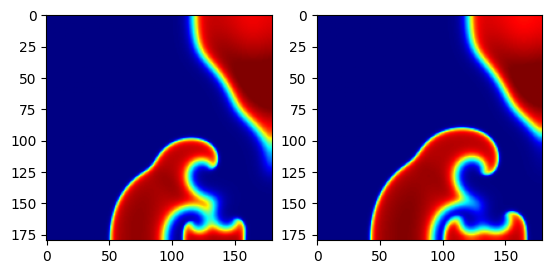

In [18]:
############ Example check to verify the input and the output images 

data=np.load('Training_Datset_Folder/File_1.npy.npz')
x=data['array_1']
y=data['array_2']
print(x.shape,y.shape)

plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)
plt.show()

In [ ]:
start_time=time.time()
################################ Validation dataset ##########################

######################### SDC

img_no=0
NNN=0
for NNN in range(len(Noise_Num_val_SDC)):

    path = r'SDC_images_Folder/SDC/images_IC_'+str(Noise_Num_val_SDC[NNN])
    all_files = sorted(glob.glob(os.path.join(path,"*.png")))
    #print(len(all_files))
    images = np.empty(())
    i=0
    for filename in all_files:
        i=i+1
        #if i%100==0:
            #print(i)
        
        img=Image.open(filename)
        img=np.array(img)
        if i==1:
            img=np.expand_dims(img,axis=0)
            images=img
        else:    
            img=np.expand_dims(img,axis=0)
            images=np.append(images,img,axis=0)

    print(NNN,len(all_files))

    NN=images.shape[0]
    dataset=images
    nSamples=dataset.shape[0]
    fps=Tlength
    L=NN-fps
    h=dataset.shape[1]
    w=dataset.shape[2]
    c=dataset.shape[3]
    
    for i in range(L):
        r=i

        for j in range(r,fps+r):
            imgs=dataset[j,:,:,:]/255
            imgs1=dataset[j+1,:,:,:]/255
            np.savez_compressed('Validation_Dataset_Folder/File_'+str(img_no)+'.npy', array_1=imgs, array_2=imgs1)
            img_no+=1
    del(images)
    del(dataset)
print(r'The number of validation pairs for SDC is ', img_no)

########################## Spiral QP

NNN=0
for NNN in range(len(Noise_Num_val_Spiral_QP)):

    path = r'Spiral_QP_images_Folder/images_QP_IC_'+str(Noise_Num_val_Spiral_QP[NNN])
    all_files = sorted(glob.glob(os.path.join(path,"*.png")))
    #print(len(all_files))
    images = np.empty(())
    i=0
    for filename in all_files:
        i=i+1
        #if i%100==0:
            #print(i)
        
        img=Image.open(filename)
        img=np.array(img)
        if i==1:
            img=np.expand_dims(img,axis=0)
            images=img
        else:    
            img=np.expand_dims(img,axis=0)
            images=np.append(images,img,axis=0)

    print(NNN,len(all_files))

    NN=images.shape[0]
    dataset=images
    nSamples=dataset.shape[0]
    fps=Tlength
    L=NN-fps
    h=dataset.shape[1]
    w=dataset.shape[2]
    c=dataset.shape[3]

    
    for i in range(L):
        r=i

        for j in range(r,fps+r):
            imgs=dataset[j,:,:,:]/255
            imgs1=dataset[j+1,:,:,:]/255
            np.savez_compressed('Validation_Dataset_Folder/File_'+str(img_no)+'.npy', array_1=imgs, array_2=imgs1)

            img_no+=1
    del(images)
    del(dataset)
print(r'The number of validation pairs for Spiral QP is ', img_no)
    
print(time.time()-start_time)

In [25]:
########################### Number of training and validation files

path=r'Training_Dataset_Folder' 
all_files = sorted(glob.glob(os.path.join(path,"*.npy.npz")))
all_files=sorted(all_files)
Num_train=len(all_files)

path=r'Validation_Dataset_Folder' 
all_files = sorted(glob.glob(os.path.join(path,"*.npy.npz")))
all_files=sorted(all_files)
Num_val=len(all_files)

print(Num_train,Num_val)

55720 23880


In [ ]:
##############################################################################
##############################################################################
# Step 2 Creating datagenerators for training and validation
##############################################################################
##############################################################################

In [10]:
################## Inputs
tmw=100
size1=180
BATCH_SIZE=20 ######## Divisible by 16100 and 8050
N_CHANNELS=3

# Parameters
params = {'dim': (size1,size1),
          'batch_size': BATCH_SIZE,
          'n_channels': N_CHANNELS,
          'shuffle': True}

print(params)

{'dim': (180, 180), 'batch_size': 20, 'n_channels': 3, 'shuffle': True}


In [11]:
############################### DATAGENERATORS ##################################
#################################################################################

class train_DataGenerator(keras.utils.Sequence): 
    def __init__(self, list_IDs, batch_size=BATCH_SIZE, dim=(size1,size1), n_channels=N_CHANNELS, shuffle=True):#'Initialization'
        self.dim = dim
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
 
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):#Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    def on_epoch_end(self): ##'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)    

    def __data_generation(self, list_IDs_temp):#'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i,ID in enumerate(list_IDs_temp):
            # Store sample
            data0 = np.load('Training_Datset_Folder/File_' + str(ID) + '.npy.npz')
            X[i,]=data0['array_1']
            y[i,]=data0['array_2']
            del(data0)
        return X,y

###################### Validation datagenerators  
    
class val_DataGenerator(keras.utils.Sequence): 
    def __init__(self, list_IDs, batch_size=BATCH_SIZE, dim=(size1,size1), n_channels=N_CHANNELS, shuffle=True):#'Initialization'
        self.dim = dim
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
 
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):#Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    def on_epoch_end(self): ##'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)    

    def __data_generation(self, list_IDs_temp):#'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i,ID in enumerate(list_IDs_temp):
            # Store sample
            data0 = np.load('Validation_Datset_Folder/File_' + str(ID) + '.npy.npz')
            X[i,]=data0['array_1']
            y[i,]=data0['array_2']
            del(data0)
        return X,y


In [29]:
################################ Train and Validation Generators with there Indices ####################################
########################################################################################################################
tindex=int(Num_Files_train)
vindex=int(Num_Files_val)

train_index = list(range(Num_Files_train))
random.shuffle(train_index)
val_index =  list(range(Num_Files_val))
random.shuffle(val_index)

#print(train_index)
save('Training_details_Folder/train_indexes.npy',train_index)
save('Training_details_Folder/val_indexes.npy',val_index)# Generators
#with tf.device("GPU"):

training_generator = train_DataGenerator(train_index, **params)
validation_generator = val_DataGenerator(val_index, **params)
print(training_generator)
print(validation_generator)

In [12]:
#### If already saved
train_index=np.load('/notebooks/June_2024_Set_1_dt_10ms/Training_details_8_June/train_indexes.npy')
val_index=np.load('/notebooks/June_2024_Set_1_dt_10ms/Training_details_8_June/val_indexes.npy')

training_generator = train_DataGenerator(train_index, **params)
validation_generator = val_DataGenerator(val_index, **params)
print(training_generator)
print(validation_generator)

In [15]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(7342, 180, 180, 3) (7342, 180, 180, 3)
(3572, 180, 180, 3) (3572, 180, 180, 3)


In [30]:
######################## Create the Conv2D Encoder-Decoder DL model architecture ########################

from tensorflow.keras.layers import MaxPool2D,UpSampling3D, Conv2D,Conv3D,Dropout


######### Number of Filters to be used

NF1=100
NF2=120
NF3=140
NF4=160

from tensorflow.keras.layers import MaxPool2D,UpSampling3D, Conv2D,Conv3D

inp = layers.Input(shape=(180,180,3))#(None, *x_train.shape[2:]))
######## Encoder-Decoder Network
x=layers.Conv2D(filters=NF1,kernel_size=3,padding="same",activation="relu",)(inp)
print(x.shape)
x=layers.MaxPool2D(strides=2,padding="same")(x)
print(x.shape)
x=layers.Conv2D(filters=NF2,kernel_size=3,padding="same",activation="relu",)(x)
print(x.shape)
x=layers.MaxPool2D(strides=2,padding="same")(x)
print(x.shape)
x=layers.Conv2D(filters=NF3,kernel_size=3,padding="same",activation="relu",)(x)
print(x.shape)
x=layers.MaxPool2D(strides=3,padding="same")(x)
print(x.shape)
x=layers.Conv2D(filters=NF4,kernel_size=3,padding="same",activation="relu",)(x)
print(x.shape)
x=layers.MaxPool2D(strides=3,padding="same")(x)
print(x.shape)
x=layers.BatchNormalization()(x)#, training=True)
print(x.shape)

print('\n')


x=layers.Conv2DTranspose(filters=NF4,kernel_size=3,strides=3,padding="same",activation="relu")(x)
print(x.shape)
x=layers.Conv2D(filters=NF4,kernel_size=2,padding="same",activation="relu")(x)
print(x.shape)


x=layers.Conv2DTranspose(filters=NF3,kernel_size=3,strides=3,padding="same",activation="relu")(x)
print(x.shape)
x=layers.Conv2D(filters=NF3,kernel_size=2,padding="same",activation="relu")(x)
print(x.shape)


x=layers.Conv2DTranspose(filters=NF2,kernel_size=3,strides=2,padding="same",activation="relu")(x)
print(x.shape)
x=layers.Conv2D(filters=NF2,kernel_size=2,padding="same",activation="relu")(x)
print(x.shape)


x=layers.Conv2DTranspose(filters=NF1,kernel_size=3,strides=2,padding="same",activation="relu")(x)
print(x.shape)
x=layers.Conv2D(filters=NF1,kernel_size=2,padding="same",activation="relu")(x)
print(x.shape)

x=layers.BatchNormalization()(x)#, training=True)
print(x.shape)

x = layers.Conv2D(filters=3, kernel_size=(2, 2), activation='sigmoid', padding='same', data_format='channels_last')(x)
print(x.shape)
model = keras.models.Model(inp, x)
model.summary()

(None, 180, 180, 100)
(None, 90, 90, 100)
(None, 90, 90, 120)
(None, 45, 45, 120)
(None, 45, 45, 140)
(None, 15, 15, 140)
(None, 15, 15, 160)
(None, 5, 5, 160)
(None, 5, 5, 160)


(None, 15, 15, 160)
(None, 15, 15, 160)
(None, 45, 45, 140)
(None, 45, 45, 140)
(None, 90, 90, 120)
(None, 90, 90, 120)
(None, 180, 180, 100)
(None, 180, 180, 100)
(None, 180, 180, 100)
(None, 180, 180, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 100)      0         
 )                                                               
                                                                 
 conv

In [ ]:
# Define modifiable training hyperparameters
Num_epochs =20000
learning_rate=0.5*1e-3

In [ ]:
######################## Training the DL model

# Define modifiable training hyperparameters
Num_epochs =20000
learning_rate=0.5*1e-3

PATH_MODEL_SAVE = r'Training_details'
model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate))


# Define the checkpoint and save the trained model
filepath = PATH_MODEL_SAVE +"/Model.h5"
cp1= ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
history_cb = tf.keras.callbacks.CSVLogger(PATH_MODEL_SAVE +'/Loss_File.csv', separator=",", append=False)

# Define callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)
callbacks_list =[cp1, history_cb, early_stopping, reduce_lr ]


# Fit the DL model to the training dataset and verify for validation dataset 
history = model.fit_generator(generator=training_generator,
                  steps_per_epoch=len(train_index) //BATCH_SIZE,
                  validation_data=validation_generator,        
                  validation_steps=len(val_index) // BATCH_SIZE,
                  epochs=Num_epochs,
                  callbacks=[callbacks_list])

/tmp/ipykernel_32/1722967725.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=training_generator,


Epoch 1/20000


2024-06-12 05:42:29.245654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/huber_loss/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2786/2786 [==============================] - ETA: 0s - loss: 3.0180e-04
Epoch 1: val_loss improved from inf to 0.00057, saving model to /notebooks/June_2024_Set_1_dt_10ms/Training_details_8_June/Model_Set_1_Cont_10.h5
2786/2786 [==============================] - 646s 229ms/step - loss: 3.0180e-04 - val_loss: 5.7221e-04
Epoch 2/20000
2786/2786 [==============================] - ETA: 0s - loss: 2.8977e-04
Epoch 2: val_loss did not improve from 0.00057
2786/2786 [==============================] - 631s 227ms/step - loss: 2.8977e-04 - val_loss: 5.7855e-04
Epoch 3/20000
2786/2786 [==============================] - ETA: 0s - loss: 2.9168e-04
Epoch 3: val_loss did not improve from 0.00057
2786/2786 [==============================] - 590s 212ms/step - loss: 2.9168e-04 - val_loss: 5.9490e-04
Epoch 4/20000
2786/2786 [==============================] - ETA: 0s - loss: 2.8778e-04
Epoch 4: val_loss improved from 0.00057 to 0.00056, saving model to /notebooks/June_2024_Set_1_dt_10ms/Training_details_8